In [1]:
import torch
import torch.nn as nn


In [2]:

class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True)
    )

  def forward(self, x):
    return self.conv_op(x)


In [3]:
class DownSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

  def forward(self, x):
    down = self.conv(x)
    p = self.pool(down)
    return down, p

In [4]:
class UpSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size = 2, stride = 2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    x = torch.cat([x1, x2], 1)
    return self.conv(x)


In [5]:
class UNet(nn.Module):

  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.down_convolution_1 = DownSample(in_channels, 64)
    self.down_convolution_2 = DownSample(64, 128)
    self.down_convolution_3 = DownSample(128, 256)
    self.down_convolution_4 = DownSample(256, 512)

    self.bottle_neck = DoubleConv(512, 1024)

    self.up_convolution_1 = UpSample(1024, 512)
    self.up_convolution_2 = UpSample(512, 256)
    self.up_convolution_3 = UpSample(256, 128)
    self.up_convolution_4 = UpSample(128, 64)

    self.out = nn.Conv2d(in_channels = 64, out_channels = num_classes, kernel_size = 1)

  def forward(self, x):
    down_1, p1 = self.down_convolution_1(x)
    down_2, p2 = self.down_convolution_2(p1)
    down_3, p3 = self.down_convolution_3(p2)
    down_4, p4 = self.down_convolution_4(p3)

    b = self.bottle_neck(p4)

    up_1 = self.up_convolution_1(b, down_4)
    up_2 = self.up_convolution_2(up_1, down_3)
    up_3 = self.up_convolution_3(up_2, down_2)
    up_4 = self.up_convolution_4(up_3, down_1)

    out = self.out(up_4)
    return out



In [6]:
# if __name__ == '__main__':
#   double_conv = DoubleConv(256, 256)
#   print(double_conv)

#   input_image = torch.rand((1, 3, 512, 512))
#   model = UNet(3, 10)
#   output = model(input_image)
#   print(output.size())



```
# This is formatted as code
```

# Testing

In [7]:
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import transforms


In [8]:
class HipHopDataset(Dataset):
  def __init__(self, root_path, test = False):
    self.root_path = root_path
    if test:
      self.images = sorted([root_path + "/images/" + i for i in os.listdir(root_path + '/images')])
      self.masks = sorted([root_path + "/masks/" + i for i in os.listdir(root_path + "/masks/")])
    else:
      self.images = sorted([root_path + "/images/" + i for i in os.listdir(root_path + "/images/")])
      self.masks = sorted([root_path + "/masks/" + i for i in os.listdir(root_path + "/masks/")])

    self.transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

  def __getitem__(self, index):
    img = Image.open(self.images[index]).convert('RGB')
    mask = Image.open(self.masks[index]).convert('L')
    return self.transform(img), self.transform(mask)

  def __len__(self):
    return len(self.images)

In [9]:
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

if __name__ == "__main__":

  LEARNING_RATE = 3e-4
  BATCH_SIZE = 8
  EPOCHS = 2
  DATA_PATH = '/content/drive/MyDrive/PracticeColab/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img'
  MODEL_SAVE_PATH = '/content/drive/MyDrive/PracticeColab/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/ModelSave.pth'

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  train_dataset = HipHopDataset(DATA_PATH)

  generator = torch.Generator().manual_seed(42)
  train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator = generator)

  train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
  val_dataloader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle = True)

  model = UNet(in_channels = 3, num_classes = 1).to(device)
  optimizer = optim.AdamW(model.parameters(), lr = LEARNING_RATE)
  criterion = nn.BCEWithLogitsLoss()

  for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    for idx, img_mask in enumerate(tqdm(train_dataloader)):
      img = img_mask[0].float().to(device)
      mask = img_mask[1].float().to(device)

      y_pred = model(img)
      optimizer.zero_grad()

      loss = criterion(y_pred, mask)
      train_running_loss += loss.item()

      loss.backward()
      optimizer.step()
    train_loss = train_running_loss / idx + 1

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
      for idx, img_mask in enumerate(tqdm(val_dataloader)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)
        loss = criterion(y_pred, mask)

        val_running_loss += loss.item()

      val_loss = val_running_loss / idx + 1

    print("-" * 30)
    print(f'Train Loss EPOCH {epoch + 1}: {train_loss:.4f}')
    print(f'Valid Loss EPOCH {epoch + 1}: {val_loss:.4f}')
    print("-" * 30)



100%|██████████| 120/120 [27:52<00:00, 13.93s/it]

 50%|█████     | 1/2 [31:29<31:29, 1889.14s/it]

------------------------------
Train Loss EPOCH 1: 1.1839
Valid Loss EPOCH 1: 1.1027
------------------------------



100%|██████████| 120/120 [30:40<00:00, 15.34s/it]

100%|██████████| 2/2 [1:04:19<00:00, 1929.96s/it]

------------------------------
Train Loss EPOCH 2: 1.0939
Valid Loss EPOCH 2: 1.0569
------------------------------


In [11]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/PracticeColab/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/ModelSave/ModelSave.pth'
torch.save(model.state_dict(), MODEL_SAVE_PATH)

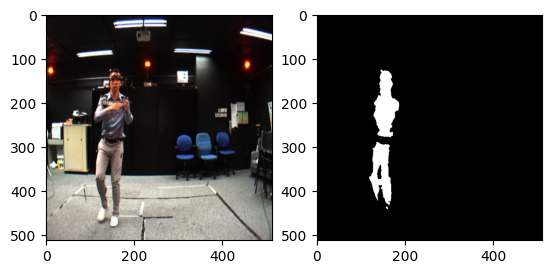

In [12]:
model_path = '/content/drive/MyDrive/PracticeColab/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/ModelSave/ModelSave.pth'
model = UNet(in_channels = 3, num_classes = 1).to(device)
model.load_state_dict(torch.load(model_path, map_location = torch.device(device)))

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

image_pth = '/content/drive/MyDrive/PracticeColab/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images/HipHop_HipHop1_C0_00675.png'
import matplotlib as plt
%matplotlib inline
from pylab import *

img = transform(Image.open(image_pth)).float().to(device)
img = img.unsqueeze(0)

pred_mask = model(img)

img = img.squeeze(0).cpu().detach()
img = img.permute(1, 2, 0)

pred_mask = pred_mask.squeeze(0).cpu().detach()
pred_mask = pred_mask.permute(1, 2, 0)
pred_mask[pred_mask < 0] = 0
pred_mask[pred_mask > 0] = 1

figs = plt.figure()
for i in range(1, 3):
  figs.add_subplot(1, 2, i)
  if i == 1:
    plt.imshow(img, cmap = 'gray')
  else:
    plt.imshow(pred_mask, cmap = 'gray')
plt.show()